In [23]:
import os
import glob
import pandas as pd
import re
from typing import Dict, List, Tuple

# 風洞運転周波数(Hz) -> 設計風速(m/s) の対応辞書
FREQ_TO_SPEED: Dict[int, float] = {0: 0.0, 14: 6.1, 26: 12.2, 38: 18.3, 50: 24.4}

folder = r"./data/calib"


def load_raw_dataframe(calib_dir: str = "./data/calib") -> pd.DataFrame:
    pattern = os.path.join(calib_dir, "*_summary.csv")
    files: List[str] = glob.glob(pattern)
    results: List[dict] = []

    for filepath in files:
        filename = os.path.basename(filepath)
        m = re.match(r"(\d+)_([0-9]+)_(up|dw)_summary\.csv", filename)
        if not m:
            continue
        meas_num, freq_str, direction = m.groups()
        freq = int(freq_str)

        with open(filepath, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f]

        # 気圧
        pressure = float(
            next(ln for ln in lines if ln.startswith("Air pressure")).split(",")[1]
        )

        # ヘッダー行（計測日時＋統計量ヘッダー）
        header_idx = next(
            i
            for i, ln in enumerate(lines)
            if re.match(r"\d{4}/\d{2}/\d{2}_\d{2}:\d{2}:\d{2},Mean", ln)
        )
        timestamp_str = lines[header_idx].split(",")[0]  # "YYYY/MM/DD_HH:MM:SS"

        # 平均電圧 (U, V) 抽出
        mean_ch1 = mean_ch2 = None
        for ln in lines[header_idx + 1 :]:
            if ln.startswith("U,"):
                mean_ch1 = float(ln.split(",")[1])
            elif ln.startswith("V,"):
                mean_ch2 = float(ln.split(",")[1])
            if mean_ch1 is not None and mean_ch2 is not None:
                break

        # 設計風速
        design_speed = FREQ_TO_SPEED.get(freq)

        # 温度データ（時刻一致）
        date_part = timestamp_str.split("_")[0]  # "YYYY/MM/DD"
        yy, mm, dd = date_part[2:4], date_part[5:7], date_part[8:10]
        temp_file = os.path.join(calib_dir, f"temperature_{yy}{mm}{dd}.csv")
        temp_c = None
        if os.path.exists(temp_file):
            temp_df = pd.read_csv(temp_file, header=None, names=["DateTime", "Temp_C"])
            target_time = timestamp_str.replace("_", " ")
            matched = temp_df[temp_df["DateTime"] == target_time]
            if not matched.empty:
                temp_c = float(matched["Temp_C"].iloc[0])

        results.append(
            dict(
                Measurement_Number=int(meas_num),
                Frequency=freq,
                Direction=direction,
                Timestamp=timestamp_str,
                Pressure_hPa=pressure,
                Mean_Ch1_Voltage_V=mean_ch1,
                Mean_Ch2_Voltage_V=mean_ch2,
                Design_Wind_Speed_m_s=design_speed,
                Temperature_C=temp_c,
            )
        )

    df = pd.DataFrame(results)
    df = df.dropna(
        subset=[
            "Temperature_C",
            "Mean_Ch1_Voltage_V",
            "Mean_Ch2_Voltage_V",
            "Design_Wind_Speed_m_s",
        ]
    ).copy()
    df["u"] = df["Design_Wind_Speed_m_s"].astype(float)
    df["v"] = 0.0
    df["U45_1"] = df["u"] + df["v"]
    df["U45_2"] = df["u"] - df["v"]
    return df.reset_index(drop=True)

In [24]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy.optimize import least_squares


# ------------------------------------------------------------
# 2) E0(T) = E00 + E01·T  推定   (無風データで線形回帰)
# ------------------------------------------------------------


def estimate_E0_linear(df: pd.DataFrame, channel: int) -> Tuple[float, float]:
    v_col = f"Mean_Ch{channel}_Voltage_V"
    # 無風点 (u = 0)
    mask = df["u"] == 0.0
    if mask.sum() < 3:
        # fallback: 最小設計風速 <= 10 %tile
        th = df["u"].quantile(0.10)
        mask = df["u"] <= th
    T = df.loc[mask, "Temperature_C"].to_numpy()
    E = df.loc[mask, v_col].to_numpy()
    A = np.vstack([np.ones_like(T), T]).T
    coef, *_ = np.linalg.lstsq(A, E, rcond=None)
    E00, E01 = coef
    print(f"Ch{channel}:  E0(T) = {E00:.6f} + {E01:.6e}·T  (N={len(T)})")
    return float(E00), float(E01)


# ----- 安全マージンを確保する補正（チャンネル共通） -----
def enforce_E0_margin(E00, E01, df, v_col, margin=0.02):
    """観測最小電圧より margin[V] だけ E0 を低くする"""
    Tmin, Tmax = df["Temperature_C"].min(), df["Temperature_C"].max()
    Vmin = df[v_col].min()
    E0_min_est = E00 + E01 * Tmin
    if E0_min_est >= Vmin - margin:
        shift = E0_min_est - (Vmin - margin)
        E00 -= shift  # 例: 0.02 V だけ下げる
    return E00, E01


# ------------------------------------------------------------
# 3) 拡張 MKL (E0 固定版)
# ------------------------------------------------------------


def extended_mkl_fixedE(
    E: np.ndarray, T: np.ndarray, params: np.ndarray, E00: float, E01: float
) -> np.ndarray:
    # params = [m10, m11, m20, m21, n]
    m10, m11, m20, m21, n = params
    m1 = m10 + m11 * T
    m2 = m20 + m21 * T
    E0 = E00 + E01 * T
    term1 = np.maximum(E**2 - E0**2, 1e-12) ** (1.0 / n)
    term2 = np.sqrt(np.maximum(E - E0, 1e-12))
    return m1 * term1 + m2 * term2


# 初期値
def initial_guess(E: np.ndarray, T: np.ndarray, U: np.ndarray) -> np.ndarray:
    """
    E, T, U の実測全ベクトルから粗い物理スケールを使って
    (m10, m11, m20, m21, n) の初期値を返す。
    """
    # 無風付近での平均電圧を推定 (5 %tile)
    E0_est = np.percentile(E, 5) * 0.95

    # 最大流速と対応する電圧差
    U_max = U.max()
    dE2 = (E.max() ** 2) - (E0_est**2)

    # m10 は U_max ≈ m10 * (dE2)^{1/2} から概算
    m10 = U_max / np.sqrt(max(dE2, 1e-6))

    # 温度依存は 0 から開始
    m11 = 0.0

    # m20 は m10 の 10 % 程度を初期値に
    m20 = 0.10 * m10
    m21 = 0.0

    # 指数 n は文献値 2.0 近辺
    n = 2.0

    return np.array([m10, m11, m20, m21, n])


# ------------------------------------------------------------
# 4) キャリブレーション & CV
# ------------------------------------------------------------


def calibrate_channel(
    df: pd.DataFrame, channel: int, E00: float, E01: float
) -> np.ndarray:
    """拡張 MKL 係数推定 + 5‑fold CV。

    旧スクリプトと同じく
      • fold ごとの RMSE
      • 設計風速ごとの最大絶対誤差とその温度
    をコンソール出力する。
    """

    v_col = f"Mean_Ch{channel}_Voltage_V"
    u_col = f"U45_{channel}"
    E = df[v_col].to_numpy()
    T = df["Temperature_C"].to_numpy()
    U = df[u_col].to_numpy()

    p0 = initial_guess(E, T, U)

    # ------ 係数推定（全データ） ------ #
    res_full = least_squares(
        lambda p: extended_mkl_fixedE(E, T, p, E00, E01) - U,
        p0,
        bounds=(np.array([0.0, -np.inf, 0.0, -np.inf, 0.5]), np.array([np.inf] * 5)),
        xtol=1e-10,
    )
    params = res_full.x

    # ------ 5‑fold CV ------ #
    print(f"\n===== Sensor {channel} : 5‑Fold CV 結果 =====")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses: List[float] = []
    for fold, (tr, te) in enumerate(kf.split(E)):
        res_cv = least_squares(
            lambda p: extended_mkl_fixedE(E[tr], T[tr], p, E00, E01) - U[tr],
            initial_guess(E[tr], T[tr], U[tr]),
            bounds=(
                np.array([0.0, -np.inf, 0.0, -np.inf, 0.5]),
                np.array([np.inf] * 5),
            ),
        )
        pred = extended_mkl_fixedE(E[te], T[te], res_cv.x, E00, E01)
        rmse = np.sqrt(mean_squared_error(U[te], pred))
        rmses.append(rmse)
        print(f" Fold {fold + 1}: RMSE = {rmse:.4f} m/s  (N = {len(te)})")
    print(f" → 平均 RMSE = {np.mean(rmses):.4f} ± {np.std(rmses):.4f} m/s")

    # ------ 設計風速ごとの最大絶対誤差 ------ #
    print("\n速度別最大絶対誤差 (全データに対し推定係数適用):")
    unique_speeds = np.sort(df["u"].unique())
    pred_all = extended_mkl_fixedE(E, T, params, E00, E01)
    abs_err = np.abs(pred_all - U)
    for spd in unique_speeds:
        idx = df["u"] == spd
        if idx.sum() == 0:
            continue
        max_idx = np.argmax(abs_err[idx])
        err_val = abs_err[idx][max_idx]
        err_T = T[idx][max_idx]
        print(
            f"  {spd:5.1f} m/s : max |err| = {err_val:.4f} m/s  (T = {err_T:.1f} °C, N = {idx.sum()})"
        )

    return params

In [25]:
# --- セル3 : 全データモデルでの誤差検証 (平均絶対誤差も追加) -------------


def full_data_error_report(
    df: pd.DataFrame, channel: int, params: np.ndarray, E00: float, E01: float
) -> None:
    """校正後の全データ誤差統計を表示 (RMSE, MAE, 速度別最大誤差)。"""
    v_col = f"Mean_Ch{channel}_Voltage_V"
    u_col = f"U45_{channel}"
    E = df[v_col].to_numpy()
    T = df["Temperature_C"].to_numpy()
    U = df[u_col].to_numpy()

    pred = extended_mkl_fixedE(E, T, params, E00, E01)
    abs_err = np.abs(pred - U)
    rmse = np.sqrt(mean_squared_error(U, pred))
    mae = np.mean(abs_err)

    print(f"==== Sensor {channel} : Full Data Error Report ====")
    print(f"  RMSE = {rmse:.4f} m/s")
    print(f"  MAE  = {mae:.4f} m/s")

    print("  速度別最大絶対誤差 :")
    for spd in np.sort(df["u"].unique()):
        idx = df["u"] == spd
        if idx.sum() == 0:
            continue
        max_err = abs_err[idx].max()
        max_T = T[idx][np.argmax(abs_err[idx])]
        print(
            f"    {spd:5.1f} m/s : max |err| = {max_err:.4f} m/s (T = {max_T:.1f} °C, N={idx.sum()})"
        )


In [26]:
# --- セル4: Sensorごとに U45_k vs V_k をプロット関数化 ---
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# フォント設定
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"


def plot_sensor_calibration_2d(
    k: int,
    params: np.ndarray,
    E00: float,
    E01: float,
    df: pd.DataFrame,
    temp_vals: tuple[float, ...] = (21, 22, 23, 24, 25, 26),
) -> None:
    """
    温度別に色分けした 2-D 校正曲線 (U-V) と実測点を描画・保存。
    """
    v_col = f"Mean_Ch{k}_Voltage_V"
    u_col = f"U45_{k}"

    V_min, V_max = df[v_col].min(), df[v_col].max()
    V_grid = np.linspace(V_min, V_max, 300)

    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = cm.get_cmap("viridis", len(temp_vals))

    # 拡張 MKL 曲線
    for idx, T0 in enumerate(temp_vals):
        U_pred = extended_mkl_fixedE(V_grid, np.full_like(V_grid, T0), params, E00, E01)
        ax.plot(
            V_grid,
            U_pred,
            color=cmap(idx),
            label=rf"$T={T0:.0f}\,\mathrm{{^\circ C}}$",
            zorder=1,
        )

    # 実測散布図
    scatter = ax.scatter(
        df[v_col],
        df[u_col],
        c=df["Temperature_C"],
        cmap="viridis",
        edgecolors="k",
        linewidths=0.3,
        alpha=0.9,
        zorder=2,
    )

    # 軸ラベル
    ax.set_xlabel(rf"Voltage $V_{k}\ \mathrm{{[V]}}$", fontsize=15)
    ax.set_ylabel(rf"Velocity $U_{{45,{k}}}\ \mathrm{{[m/s]}}$", fontsize=15)
    # ax.set_title(f"Sensor-{k} Calibration Curve")

    # 凡例（黒枠付き）
    legend = ax.legend(frameon=True, edgecolor="black", fontsize=12)
    legend.get_frame().set_linewidth(0.8)

    # カラーバー
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label(r"Temperature $T\ \mathrm{[^\circ C]}$", fontsize=14)

    # グリッド・余白タイト
    ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)
    plt.tight_layout()

    # # 軸範囲
    # ax.set_xlim(1.2, 3)

    # 保存
    today = date.today().strftime("%m%d")
    out_dir = os.path.join("figure", today)
    os.makedirs(out_dir, exist_ok=True)
    base = f"Sensor{k}_Calibration"
    fig.savefig(os.path.join(out_dir, base + ".png"), dpi=300, bbox_inches="tight")
    fig.savefig(os.path.join(out_dir, base + ".pdf"), bbox_inches="tight")

    plt.show()
    plt.close()


def plot_sensor_calibration_3d(
    k: int,
    params: np.ndarray,
    E00: float,
    E01: float,
    df: pd.DataFrame,
    elev: float = 30,
    azim: float = 315,
) -> None:
    """
    温度 (T) – 電圧 (V) – 速度 (U) の 3-D 校正面と実測散布図を描画・保存。
    """

    v_col = f"Mean_Ch{k}_Voltage_V"
    u_col = f"U45_{k}"

    # ---------- メッシュ生成 ----------
    V_lin = np.linspace(df[v_col].min(), df[v_col].max(), 60)
    T_lin = np.linspace(df["Temperature_C"].min(), df["Temperature_C"].max(), 25)
    VV, TT = np.meshgrid(V_lin, T_lin)

    # 各列(=温度)ごとに U45
    UU = extended_mkl_fixedE(VV, TT, params, E00, E01)

    # ---------- カラーマップ（温度基準） ----------
    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(T_lin.min(), T_lin.max())
    facecolors = cmap(norm(TT))

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    # 校正曲面
    surf = ax.plot_surface(
        TT,
        VV,
        UU,
        facecolors=facecolors,
        ccount=len(T_lin),
        shade=False,
        linewidth=0,
        alpha=0.6,
        zorder=1,
    )

    # 実測点
    p = ax.scatter(
        df["Temperature_C"],
        df[v_col],
        df[u_col],
        c=df["Temperature_C"],
        cmap="viridis",
        norm=norm,
        edgecolors="k",
        linewidths=0.3,
        zorder=2,
    )

    # ---------- カラーバー（温度） ----------
    cbar = fig.colorbar(p, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label(r"Temperature $T\ \mathrm{[^\circ C]}$", fontsize=15)

    # ---------- 凡例 ----------
    scatter_proxy = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="gray",
        markeredgecolor="k",
        markersize=6,
    )
    surface_proxy = plt.Line2D(
        [0], [0], marker="s", color="w", markerfacecolor="lightgray", markersize=8
    )
    leg = ax.legend(
        [surface_proxy, scatter_proxy],
        ["Calibration surface", "Measured"],
        frameon=True,
        framealpha=1,
        edgecolor="black",
        loc=(0.1, 0.65),
        fontsize=12,
    )
    leg.get_frame().set_linewidth(0.8)
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()

    # ---------- 保存 ----------
    today = date.today().strftime("%m%d")
    out_dir = os.path.join("figure", today)
    os.makedirs(out_dir, exist_ok=True)
    base = f"Sensor{k}_Calibration_3D"
    fig.savefig(os.path.join(out_dir, base + ".png"), dpi=300, bbox_inches="tight")
    fig.savefig(os.path.join(out_dir, base + ".pdf"), bbox_inches="tight")

    plt.show()
    plt.close()


# 拡張 MKL（E0 固定）を呼び出す関数が既に定義済みである前提
# def extended_mkl_fixedE(E, T, params, E00, E01): ...


def plot_temp_vs_U45_MKL(
    k: int,
    params: np.ndarray,
    E00: float,
    E01: float,
    df: pd.DataFrame,
    V_vals: list[float] = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0],
) -> None:
    """
    V_k = 1.5–4.0 V のときの T–U45 曲線を重ね描き（拡張 MKL 版）
    ----------------------------------------------------------------
    Parameters
    ----------
    k       : int            センサ番号 (1 or 2)
    params  : ndarray        [m10, m11, m20, m21, n]
    E00,E01 : float          E0(T) = E00 + E01*T の係数
    df      : DataFrame      温度範囲取得用（min/max を使うだけ）
    V_vals  : list[float]    プロットする電圧値 [V]
    """
    # 温度範囲
    T_min, T_max = df["Temperature_C"].min(), df["Temperature_C"].max()
    T_grid = np.linspace(T_min, T_max, 400)

    # 作図
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.get_cmap("viridis", len(V_vals))

    for idx, V in enumerate(V_vals):
        U_pred = extended_mkl_fixedE(
            np.full_like(T_grid, V),  # E
            T_grid,  # T
            params,
            E00,
            E01,
        )
        ax.plot(
            T_grid,
            U_pred,
            color=cmap(idx),
            label=rf"$V={V:.1f}\,\mathrm{{V}}$",
            linewidth=1.6,
            zorder=1,
        )

    # 軸ラベル
    ax.set_xlabel(r"Temperature $T\;[\!^\circ\mathrm{C}]$", fontsize=14)
    ax.set_ylabel(rf"Velocity $U_{{45,{k}}}\;[\mathrm{{m/s}}]$", fontsize=14)

    # 凡例・グリッド
    leg = ax.legend(frameon=True, edgecolor="black", fontsize=11)
    leg.get_frame().set_linewidth(0.8)
    ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)

    plt.tight_layout()

    # 保存
    today = date.today().strftime("%m%d")
    out_dir = os.path.join("figure", today)
    os.makedirs(out_dir, exist_ok=True)
    base = f"Sensor{k}_Temp_vs_U45_MKL"
    fig.savefig(os.path.join(out_dir, base + ".png"), dpi=300, bbox_inches="tight")
    fig.savefig(os.path.join(out_dir, base + ".pdf"), bbox_inches="tight")
    plt.show()


Ch1:  E0(T) = 1.861673 + -1.405642e-02·T  (N=32)
Ch2:  E0(T) = 2.100164 + -1.180553e-02·T  (N=32)
Ch-1  E₀(T) range: 1.467198 – 1.3881460309050278
Ch-1  観測電圧 V range: 1.487198 – 3.966273

===== Sensor 1 : 5‑Fold CV 結果 =====
 Fold 1: RMSE = 0.1037 m/s  (N = 32)
 Fold 2: RMSE = 0.0927 m/s  (N = 32)
 Fold 3: RMSE = 0.1015 m/s  (N = 32)
 Fold 4: RMSE = 0.1034 m/s  (N = 32)
 Fold 5: RMSE = 0.0755 m/s  (N = 32)
 → 平均 RMSE = 0.0954 ± 0.0107 m/s

速度別最大絶対誤差 (全データに対し推定係数適用):
    0.0 m/s : max |err| = 0.0737 m/s  (T = 23.0 °C, N = 32)
    6.1 m/s : max |err| = 0.1147 m/s  (T = 24.0 °C, N = 32)
   12.2 m/s : max |err| = 0.1494 m/s  (T = 21.4 °C, N = 32)
   18.3 m/s : max |err| = 0.2424 m/s  (T = 21.7 °C, N = 32)
   24.4 m/s : max |err| = 0.3453 m/s  (T = 22.6 °C, N = 32)

===== Sensor 2 : 5‑Fold CV 結果 =====
 Fold 1: RMSE = 0.1068 m/s  (N = 32)
 Fold 2: RMSE = 0.0848 m/s  (N = 32)
 Fold 3: RMSE = 0.0968 m/s  (N = 32)
 Fold 4: RMSE = 0.1064 m/s  (N = 32)
 Fold 5: RMSE = 0.0709 m/s  (N = 32)
 → 平均 RM

C:\Users\Senri\AppData\Local\Temp\ipykernel_2736\3508121104.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(temp_vals))


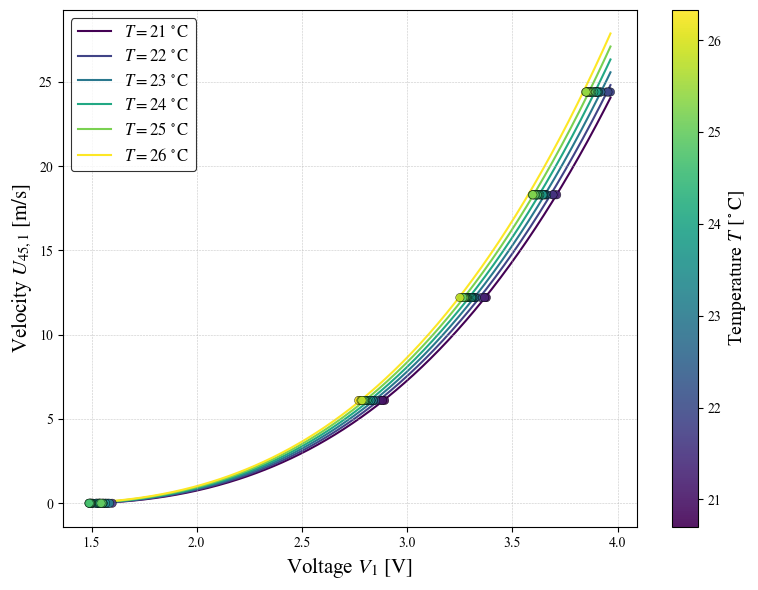

C:\Users\Senri\AppData\Local\Temp\ipykernel_2736\3508121104.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(temp_vals))


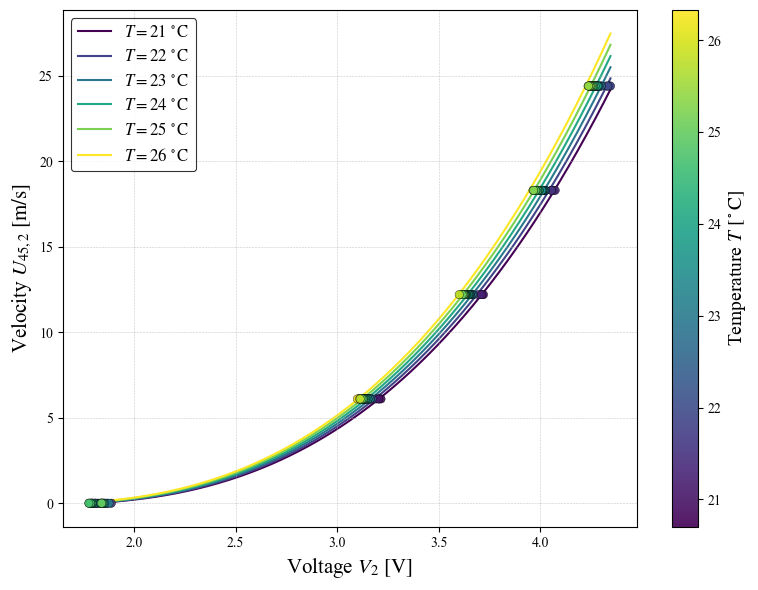

C:\Users\Senri\AppData\Local\Temp\ipykernel_2736\3508121104.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


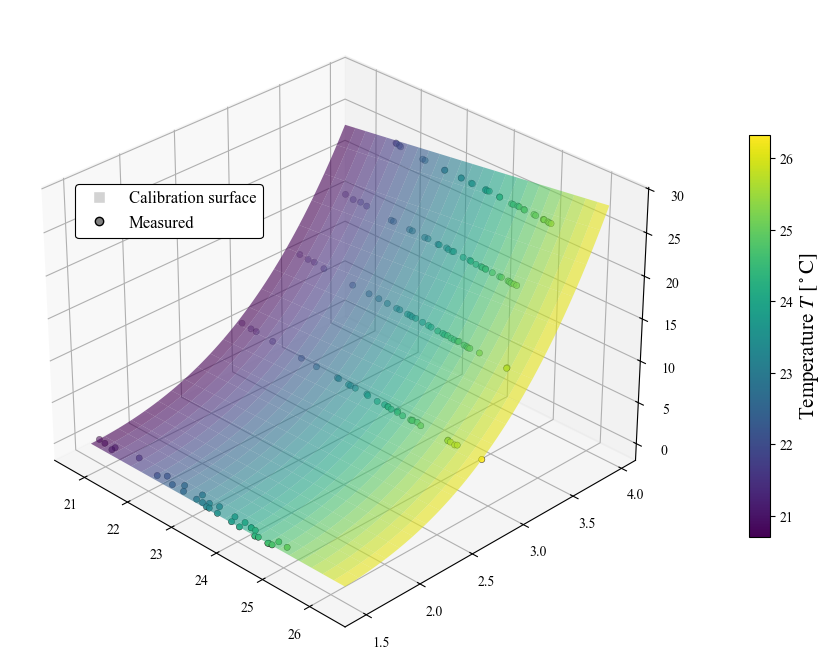

C:\Users\Senri\AppData\Local\Temp\ipykernel_2736\3508121104.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


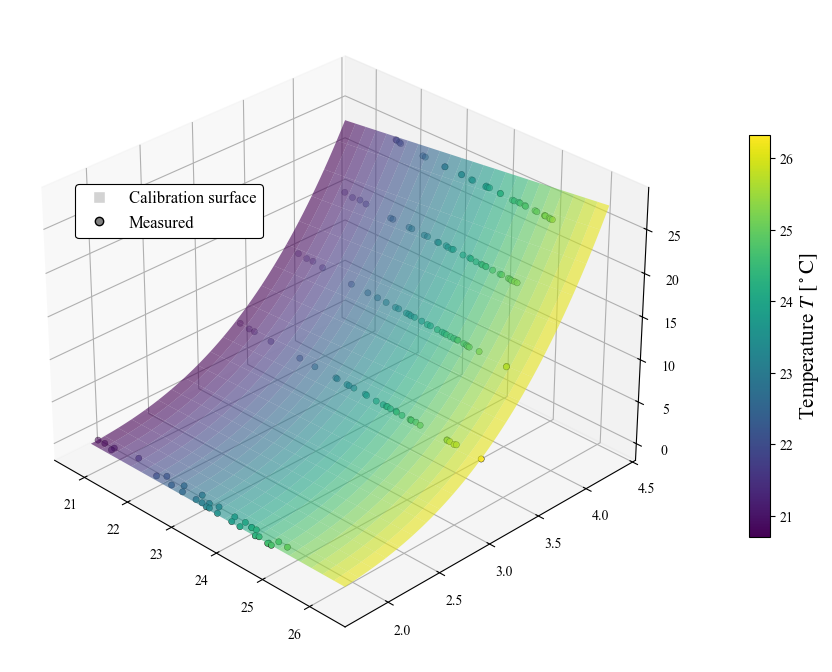

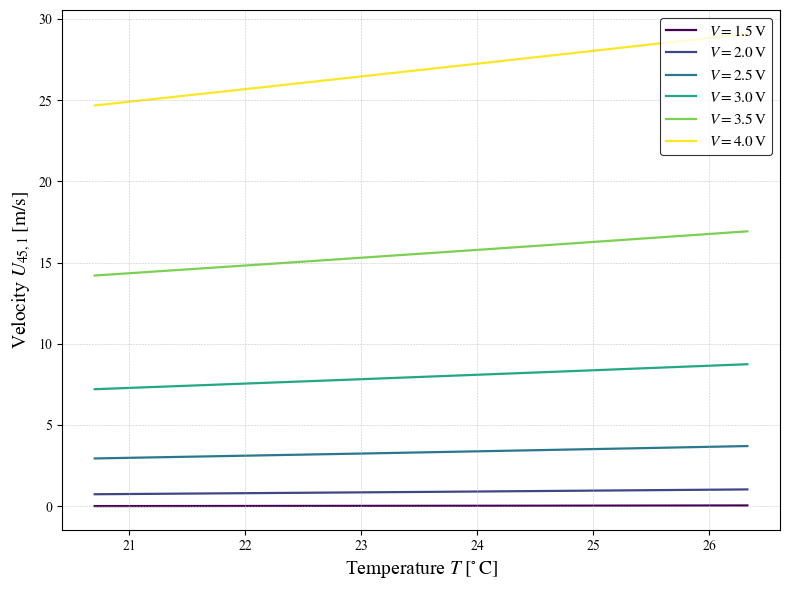

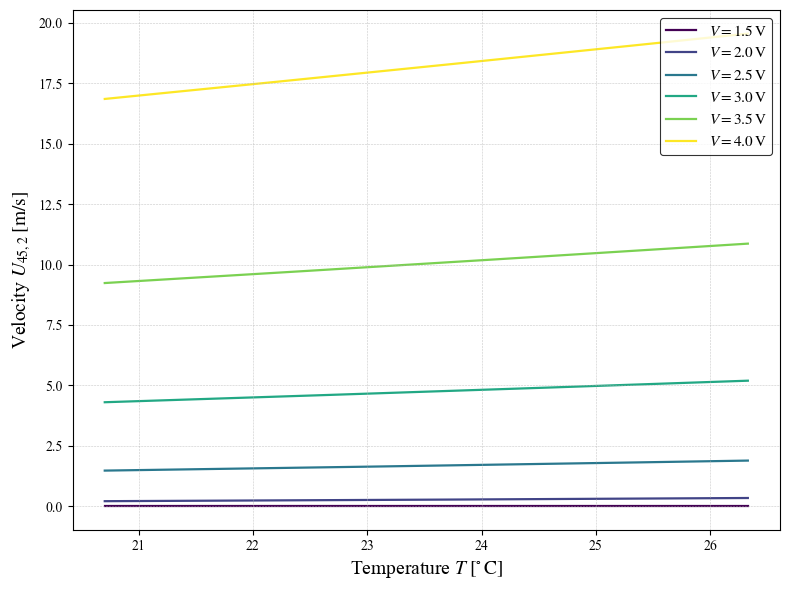


=== 推定係数まとめ ===

Sensor-1:
   m10 =  0.114266
   m11 =  0.00643325
   m20 =  8.4976e-13
   m21 =  0.000833325
     n =  0.57121
   E00 =  1.75821
   E01 = -0.0140564

Sensor-2:
   m10 =  0.107702
   m11 =  0.00422227
   m20 =  0.141754
   m21 =  0.0101586
     n =  0.571441
   E00 =  2.10016
   E01 = -0.0118055


In [27]:
# ---------------------------- 実行エントリ ---------------------------- #
def main() -> None:
    """拡張MKLキャリブレーション一括実行"""
    # 1) データ読み込み
    df = load_raw_dataframe()

    # 2) E₀(T) 推定（チャンネル別）
    E00_1, E01_1 = estimate_E0_linear(df, channel=1)
    E00_1, E01_1 = enforce_E0_margin(
        E00_1, E01_1, df, "Mean_Ch1_Voltage_V", margin=0.02
    )

    E00_2, E01_2 = estimate_E0_linear(df, channel=2)
    # E00_2, E01_2 = enforce_E0_margin(
    #     E00_2, E01_2, df, "Mean_Ch2_Voltage_V", margin=0.02
    # )
    print(
        "Ch-1  E₀(T) range:",
        (E00_1 + E01_1 * df["Temperature_C"].min()),
        "–",
        (E00_1 + E01_1 * df["Temperature_C"].max()),
    )
    print(
        "Ch-1  観測電圧 V range:",
        df["Mean_Ch1_Voltage_V"].min(),
        "–",
        df["Mean_Ch1_Voltage_V"].max(),
    )

    # 3) 拡張MKL係数推定
    params1 = calibrate_channel(df, channel=1, E00=E00_1, E01=E01_1)
    params2 = calibrate_channel(df, channel=2, E00=E00_2, E01=E01_2)

    # 4) 全データモデルでの誤差検証
    full_data_error_report(df, channel=1, params=params1, E00=E00_1, E01=E01_1)
    full_data_error_report(df, channel=2, params=params2, E00=E00_2, E01=E01_2)

    # 4) 可視化（PNG／PDF を figure/<mmdd>/ に保存）
    plot_sensor_calibration_2d(1, params1, E00_1, E01_1, df)
    plot_sensor_calibration_2d(2, params2, E00_2, E01_2, df)
    plot_sensor_calibration_3d(1, params1, E00_1, E01_1, df)
    plot_sensor_calibration_3d(2, params2, E00_2, E01_2, df)

    plot_temp_vs_U45_MKL(1, params1, E00_1, E01_1, df)
    plot_temp_vs_U45_MKL(2, params2, E00_2, E01_2, df)

    # 5) 係数をコンソールに表示
    print("\n=== 推定係数まとめ ===")

    param_names = ["m10", "m11", "m20", "m21", "n", "E00", "E01"]

    print("\nSensor-1:")
    for name, val in zip(param_names, list(params1) + [E00_1, E01_1]):
        print(f"  {name:>4s} = {val: .6g}")

    print("\nSensor-2:")
    for name, val in zip(param_names, list(params2) + [E00_2, E01_2]):
        print(f"  {name:>4s} = {val: .6g}")


# スクリプトとして実行された場合のみ main() を走らせる
if __name__ == "__main__":
    main()